# Задание 2 Анализ А/В теста

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-05-24 по 2022-05-30 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

# Загружаем библиотеки и подключаемся к базе

In [2]:
import hashlib
import pandahouse
import pandas as pd
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import numpy as np
import warnings
pd.set_option('display.float_format', '{:.5f}'.format)
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15,7)})

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [4]:
q = '''SELECT user_id, exp_group,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
from simulator_20220620.feed_actions 
group by user_id, exp_group
having toDate(time)>='2022-05-24' and toDate(time)<='2022-05-30' and exp_group in (1,2) 
'''

In [5]:
df = pandahouse.read_clickhouse(query=q, connection=connection)

In [6]:
df['exp_group'].replace(1,'control', inplace=True)
df['exp_group'].replace(2,'test', inplace=True)

# Подготовка и сам анализ теста

Проверяем базовые статистики по тестовой и контрольной группам.

In [7]:
df.groupby('exp_group').ctr.describe()

,count,mean,std,min,25%,50%,75%,max
exp_group,,,,,,,,
control,10079.00000,0.21560,0.08416,0.00000,0.16010,0.20312,0.25765,0.72222
test,9952.00000,0.21442,0.14418,0.00000,0.09524,0.14286,0.32500,0.92308


Средний ctr по группам очень похожее, для тестового чуть меньше (21,44% против 21,56%). 
Но стандартное отклонение по тестовой выборке намного выше. Кроме того, видно, что крайние квартили по тестовой выборке тоже сильно отличаются от контрольной. Посмотрим на их гистограммы

Text(0.5, 1.0, 'Распределения CTR в тестовой и контрольной группах')

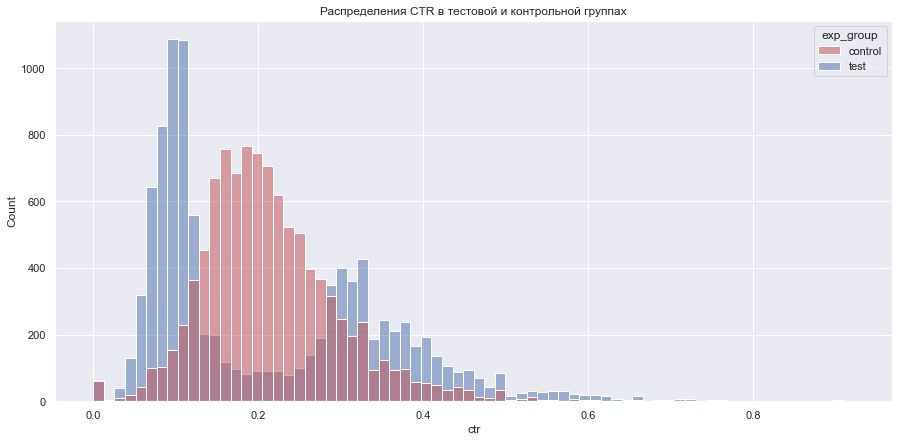

In [8]:
sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r','b'])
plt.title('Распределения CTR в тестовой и контрольной группах')

Гистограмма показывает что-то неожиданное. Для тестовой выборки есть 2 горба - в районе 10% и в районе 30%. Горб в районе 10% больше (второй менее размазан). Для контрольной - распределение похоже на нормальное с центром в районе 20%.
Предполагаю, что эксперимент дал разные результаты - у кого-то ухудшил ctr, у кого-то увеличил. 
Надо будет изучить эти группы (1 - у кого ухудшили и 2 - у кого улучшили) отдельно - по профилю (ос, пол-возраст и т.д.) и поведению (кол-во просмотров и т.д. и т.п.)

# т-тест Стьюдента

In [9]:
_, pvalue = stats.ttest_ind(df[df['exp_group']=='test'].ctr, df[df['exp_group']=='control'].ctr,
                            equal_var=False)
pvalue

0.4780623130874935

## Вывод по т-тесту Стьюдента
Стандартный т-тест дает pvalue сильно больше 0.05, то есть он говорит, что выборки не одинаковые.

# Манна-Уитни

In [10]:
df_ctr_tst = df[df['exp_group']=='test']
df_ctr_ctrl = df[df['exp_group']=='control']

In [11]:
_, pvalue_mw = stats.mannwhitneyu(df_ctr_tst.ctr, df_ctr_ctrl.ctr)
pvalue_mw

6.0376484617779035e-56

Теперь сравним по случайным значениям из теста и контроля

In [12]:
A_gt_B = 0
n_samples = 10**5

for _ in range(n_samples):
    A_gt_B+= df_ctr_tst.ctr.sample().values[0] > df_ctr_ctrl.ctr.sample().values[0]
    
print('В', round((A_gt_B/n_samples)*100, 2), '% случаев test > control. Должно получиться около 50%')

В 43.41 % случаев test > control. Должно получиться около 50%


## Вывод по тесту Манна-Уитни
Нулевая гипотеза (ранги выборок одинаковые) отвергнута (и по pvalue, и по сравнению случайных значений). Это значит, что распределения выборок разные.

#  Пуассоновский бутстреп

In [13]:
n_test = df_ctr_tst.shape[0]
n_control = df_ctr_ctrl.shape[0]

n_samples = 5000

poisson_samples_tst = stats.poisson(1).rvs((n_samples, n_test))
poisson_samples_ctrl = stats.poisson(1).rvs((n_samples, n_control))

Проверим разброс выборок - сколько раз выпадало каждое из значений

Text(0.5, 1.0, 'Разброс выборок для тестовой группы')

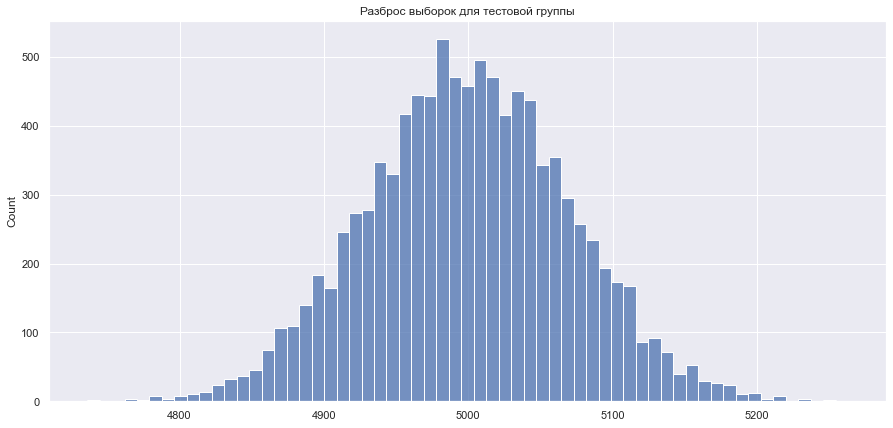

In [14]:
sns.histplot(sum(poisson_samples_tst))
plt.title('Разброс выборок для тестовой группы')

Text(0.5, 1.0, 'Разброс выборок для контрольной группы')

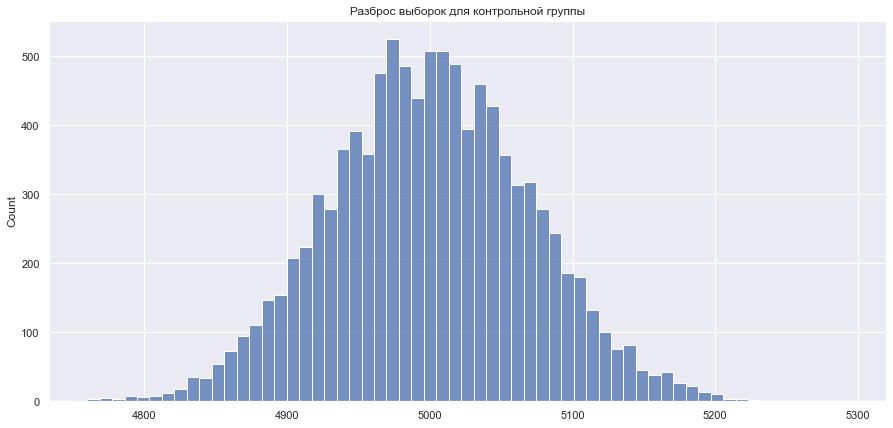

In [15]:
sns.histplot(sum(poisson_samples_ctrl))
plt.title('Разброс выборок для контрольной группы')

Визуально разница очень маленькая. Дальше нам надо посчитать глобальный ctr для каждой выборки.

In [16]:
ctr_pois_tst = (poisson_samples_tst * df_ctr_tst.likes.to_numpy()).sum(axis=1) / (poisson_samples_tst * df_ctr_tst.views.to_numpy()).sum(axis=1)
ctr_pois_ctrl = (poisson_samples_ctrl * df_ctr_ctrl.likes.to_numpy()).sum(axis=1) / (poisson_samples_ctrl * df_ctr_ctrl.views.to_numpy()).sum(axis=1)

Теперь нарисуем их:

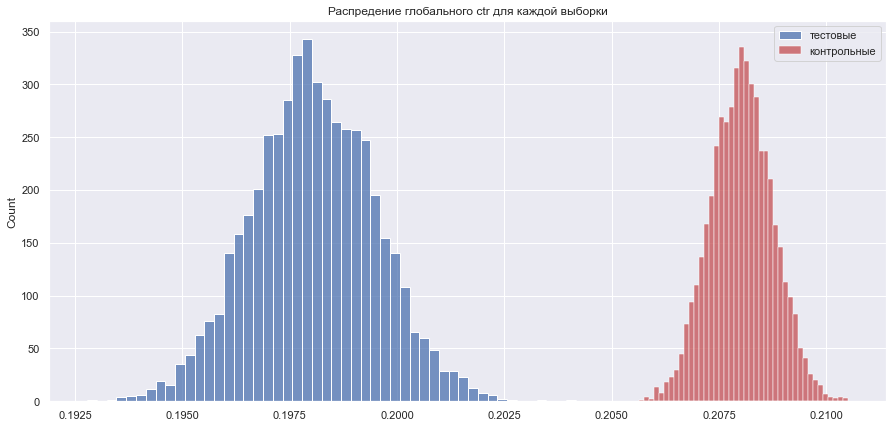

In [17]:
sns.histplot(ctr_pois_tst, color='b')
sns.histplot(ctr_pois_ctrl, color='r')
plt.title('Распредение глобального ctr для каждой выборки')
plt.legend(['тестовые', 'контрольные'])

Можно заметить, что тестовые значения ниже чем контрольные и разница проявилась в отличие от т-теста очень сильно.

Text(0.5, 1.0, 'Распределение разностей теста и контроля')

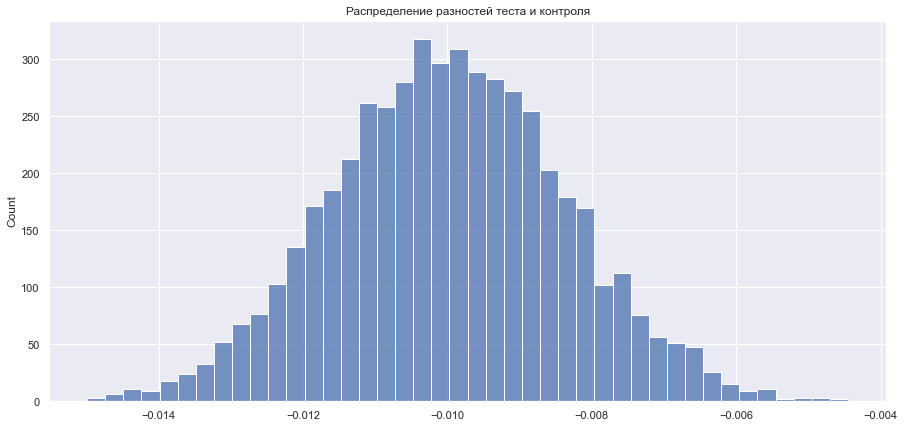

In [18]:
sns.histplot(ctr_pois_tst - ctr_pois_ctrl)
plt.title('Распределение разностей теста и контроля')

## Вывод по пуассоновскому бутстрепу
Всё распределение разностей теста и контроля (пуассоновским бутстрепом) находится в отрицальной зоне, это значит, что тестовый CTR сильно меньше контрольного(что в принципе видно по распределениям). Новый алгоритм во 2-й группе не привел к увеличению CTR.

# Тесты на сглаженном CTR
Посомтрим как ведут себя тесты на сглаженном распределении CTR.

In [19]:
def smoothed_ctr(like, view, general_ctr, alpha):
    return (like + alpha*general_ctr) / (view + alpha)

Опять считаем глобальные CTR:

In [20]:
global_ctr_tst = df_ctr_tst.likes.sum() / df_ctr_tst.views.sum()
global_ctr_ctrl = df_ctr_ctrl.likes.sum() / df_ctr_ctrl.views.sum()

А теперь сглаживаем:

In [21]:
df_ctr_tst['smoothed_ctr'] = df_ctr_tst.apply(
    lambda x: smoothed_ctr(x['likes'], x['views'], global_ctr_tst, 5), axis=1)

df_ctr_ctrl['smoothed_ctr'] = df_ctr_ctrl.apply(
    lambda x: smoothed_ctr(x['likes'], x['views'], global_ctr_ctrl, 5), axis=1)

Посмотрим на статистику и на распределения:

In [22]:
pd.DataFrame(dict(control = df_ctr_tst.smoothed_ctr.describe(), test = df_ctr_ctrl.smoothed_ctr.describe()))

,control,test
count,9952.00000,10079.00000
mean,0.21074,0.21403
std,0.12477,0.07137
min,0.03095,0.03587
25%,0.10512,0.16454
50%,0.14788,0.20348
75%,0.31090,0.25167
max,0.77063,0.62311


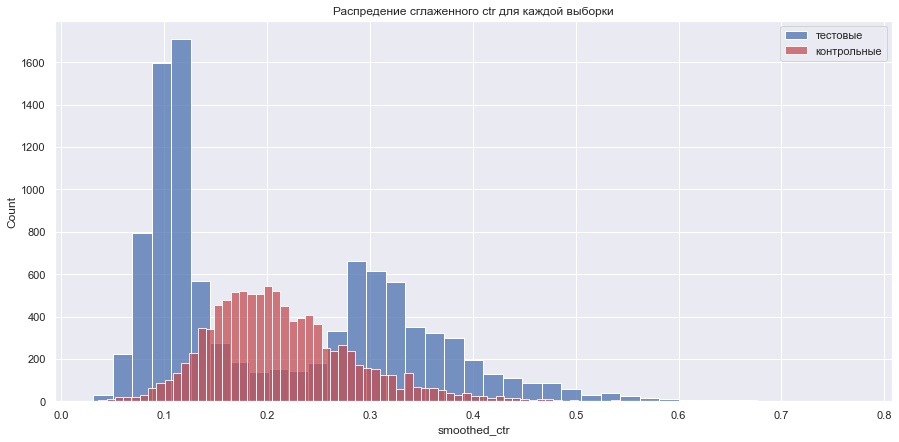

In [23]:
sns.histplot(df_ctr_tst.smoothed_ctr, color='b')
sns.histplot(df_ctr_ctrl.smoothed_ctr, color='r')
plt.title('Распредение сглаженного ctr для каждой выборки')
plt.legend(['тестовые', 'контрольные'])

## т-тест Стьюдента по сглаженному CTR

In [24]:
_, pvalue = stats.ttest_ind(df_ctr_tst.ctr, df_ctr_ctrl.ctr, equal_var=False)
_, pvalue_smoothed = stats.ttest_ind(df_ctr_tst.smoothed_ctr, df_ctr_ctrl.smoothed_ctr, equal_var=False)
print(f'P-value т-теста для обычного ctr = {pvalue}, для сглаженного ctr = {pvalue_smoothed}')

P-value т-теста для обычного ctr = 0.4780623130874935, для сглаженного ctr = 0.0223769815558559


По сглаженному ctr т-тест покрасился.

## Манна-Уитни по сглаженному CTR

In [25]:
_, pvalue_mw = stats.mannwhitneyu(df_ctr_tst.ctr, df_ctr_ctrl.ctr)
_, pvalue_mw_sm = stats.mannwhitneyu(df_ctr_tst.smoothed_ctr, df_ctr_ctrl.smoothed_ctr)
print(f'P-value теста Манна-Уитни для обычного ctr = {pvalue_mw}, для сглаженного ctr = {pvalue_mw_sm}')

P-value теста Манна-Уитни для обычного ctr = 6.0376484617779035e-56, для сглаженного ctr = 1.6163964114270227e-61


Манн-Уитни и до сглаживания был маленький(тест покрашивался), теперь еще меньше.

# Бакетное преобразование

Попробуем реализовать бакетное преобразование, начнем с хэширования. Будем делить на 100 групп (мета-юзеров)

In [26]:
def ab_split(id, salt='exp_mess_1', n_groups=100):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [27]:
df_ctr_tst['backet'] = df_ctr_tst.user_id.apply(ab_split)
df_ctr_ctrl['backet'] = df_ctr_ctrl.user_id.apply(ab_split)

И посчитаем CTR

In [28]:
df_ctr_tst_backet = df_ctr_tst.groupby('backet').likes.sum() / df_ctr_tst.groupby('backet').views.sum()
df_ctr_ctrl_backet = df_ctr_ctrl.groupby('backet').likes.sum() / df_ctr_ctrl.groupby('backet').views.sum()

## т-тест по бакетному преобразованию

In [29]:
_, pvalue = stats.ttest_ind(df_ctr_tst.ctr, df_ctr_ctrl.ctr, equal_var=False)
_, pvalue_backet = stats.ttest_ind(df_ctr_tst_backet, df_ctr_ctrl_backet, equal_var=False)
print(f'P-value т-теста для обычного ctr = {pvalue}, для сглаженного = {pvalue_smoothed}, для бакетного ctr = {pvalue_backet}')

P-value т-теста для обычного ctr = 0.4780623130874935, для сглаженного = 0.0223769815558559, для бакетного ctr = 5.4294865493877956e-08


## тест Манна-Уитни по бакетному преобразованию

In [30]:
_, pvalue_mw = stats.mannwhitneyu(df_ctr_tst.ctr, df_ctr_ctrl.ctr)
_, pvalue_mw_backet = stats.mannwhitneyu(df_ctr_tst_backet, df_ctr_ctrl_backet)
print(f'P-value теста Манна-Уитни для обычного ctr = {pvalue_mw}, для сглаженного ctr = {pvalue_mw_sm}, для бакетного ctr = {pvalue_mw_backet}')

P-value теста Манна-Уитни для обычного ctr = 6.0376484617779035e-56, для сглаженного ctr = 1.6163964114270227e-61, для бакетного ctr = 2.0110869513991762e-07


Тест Манна-Уитни прокрашивается во всех случаях, после бактеного стал прокрашиваться меньше (возможно из-за уменьшения выборки через хэширование).

# Выводы

Почти все тесты показали, что выборки не одинаковые. Это можно увидеть по распределениям и квартилям. Эксперимент привел к тому, что для одних пользователей CTR стал меньше, а для других вырос. Предположу причины такого результата:
  - Разные группы пользователей по-разному реагируют на сам алгоритм. Например, одним может не нравится, что им алгоритм выдает не те посты, к которым они привыкли, им не нравятся изменения т.д., а другие лояльны к нашему алгоритму и изменения им подуше.
  - Ошибка в алгоритме. Для одних он работал хорошо, для других работал с ошибкой в алгоритме. Эксперимент имеет хороший потенциал, потому что для тех у кого CTR упал алгоритм можно отключить. Тогда общий CTR вырастет, чего мы и добивались.
  
  
Рекомендации:

- учитывая сильное падение CTR для примерно половины тестовых пользователей, лучше остановить эксперимент.
- найти причины проблемы. Начать с изучения алгоритма. 
- изучать 2 группы - у которых CTR вырос, и у которых упал. Возможно есть какие-то особенности. 
- провести повторный тест после исправлений
- если повторный тест окажется успешным, то можно дать новый алгоритм всем пользователям.